In [1]:
import boto3
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score


## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'predictive_analytics/train(1).csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
train_data = pd.read_csv(file_content_stream)
train_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [2]:
train_data['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

Make 2 visualizations

<AxesSubplot: xlabel='product_code', ylabel='measurement_2'>

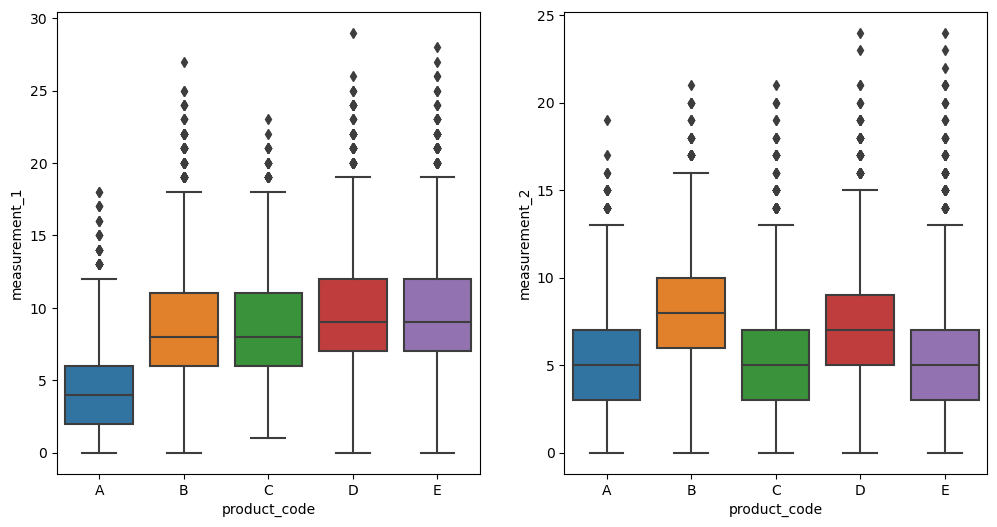

In [3]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.boxplot(ax = axes[0], x = 'product_code', y = 'measurement_1', data = train_data)
sns.boxplot(ax = axes[1], x = 'product_code', y = 'measurement_2', data = train_data)

## Imputing Missing Values With KNN

<dl>
    <dt> Summary </dt>
    <dd>Product code A typically has a lower value for measurement 1. Product Codes B and C typically have a higher value in measurement 2</dd>
</dl>

In [8]:
## Inputs and Target ##
X = train_data.drop(columns = ['failure', 'attribute_0', 'attribute_1', 'id'])
Y = train_data['failure']

## Split Data ##
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)

## Define Imputer ##
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(X_train.drop(columns = 'product_code'))

## Impute Values ##
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train.drop(columns = 'product_code')), columns = X_train.drop(columns = 'product_code').columns)
X_test_imp = pd.DataFrame(imputer.fit_transform(X_test.drop(columns = 'product_code')), columns = X_test.drop(columns = 'product_code').columns)

## First Model

In [9]:
## Model ##
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train_imp, Y_train)

## Prediction ##
rf_pred = rf_md.predict_proba(X_test_imp)[:, 1]

## Label ##
print('The ROC Score for the Random Forest Model is:', roc_auc_score(Y_test, rf_pred))

The ROC Score for the Random Forest Model is: 0.5761764158445998


## Second Model using product code

In [10]:
X_train['product_code'].value_counts()

C    4568
E    4317
B    4195
A    4103
D    4073
Name: product_code, dtype: int64

In [11]:
A_train = X_train[X_train['product_code'] == 'A'].drop(columns = 'product_code')
B_train = X_train[X_train['product_code'] == 'B'].drop(columns = 'product_code')
C_train = X_train[X_train['product_code'] == 'C'].drop(columns = 'product_code')
D_train = X_train[X_train['product_code'] == 'D'].drop(columns = 'product_code')
E_train = X_train[X_train['product_code'] == 'E'].drop(columns = 'product_code')

A_test = X_test[X_test['product_code'] == 'A'].drop(columns = 'product_code')
B_test = X_test[X_test['product_code'] == 'B'].drop(columns = 'product_code')
C_test = X_test[X_test['product_code'] == 'C'].drop(columns = 'product_code')
D_test = X_test[X_test['product_code'] == 'D'].drop(columns = 'product_code')
E_test = X_test[X_test['product_code'] == 'E'].drop(columns = 'product_code')

Do I need to split up the testing data as well? How do I fit the imputer to the As?

In [16]:
## Inputs and Target ##
X = train_data.drop(columns = ['failure', 'attribute_0', 'attribute_1', 'product_code', 'id'])
Y = train_data['failure']

## Split Data ##
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)

## A ##
## Define Imputer ##
A_imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(A_train)

## Impute Values ##
A_train_imp = pd.DataFrame(imputer.fit_transform(A_train), columns = A_test.columns)
A_test_imp = pd.DataFrame(imputer.fit_transform(A_test), columns = A_test.columns)

## B ##
## Define Imputer ##
B_imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(B_train)

## Impute Values ##
B_train_imp = pd.DataFrame(imputer.fit_transform(B_train), columns = B_test.columns)
B_test_imp = pd.DataFrame(imputer.fit_transform(B_test), columns = B_test.columns)

## C ##
C_imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(C_train)

## Impute Values ##
C_train_imp = pd.DataFrame(imputer.fit_transform(C_train), columns = C_test.columns)
C_test_imp = pd.DataFrame(imputer.fit_transform(C_test), columns = C_test.columns)

## D ##
D_imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(D_train)

## Impute Values ##
D_train_imp = pd.DataFrame(imputer.fit_transform(D_train), columns = D_test.columns)
D_test_imp = pd.DataFrame(imputer.fit_transform(D_test), columns = D_test.columns)

## E ##
E_imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(E_train)

## Impute Values ##
E_train_imp = pd.DataFrame(imputer.fit_transform(E_train), columns = E_test.columns)
E_test_imp = pd.DataFrame(imputer.fit_transform(E_test), columns = E_test.columns)

## Reasemble Data Frames ##
X_train_imp = pd.concat([A_train_imp, B_train_imp, C_train_imp, D_train_imp, E_train_imp])
X_test_imp = pd.concat([A_test_imp, B_test_imp, C_test_imp, D_test_imp, E_test_imp])


## Model ##
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train_imp, Y_train)

## Prediction ##
rf_pred = rf_md.predict_proba(X_test_imp)[:, 1]

## Label ##
print('The ROC Score for the Random Forest Model is:', roc_auc_score(Y_test, rf_pred))

The ROC Score for the Random Forest Model is: 0.48059548384913453


Based on my results, Imputing the data based on product code is now bennificial. The first random forest model preformed better and is the method I would use to predict failure